## Mengimport Library

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import ndcg_score
from tabulate import tabulate
import warnings

## Loading Dataset

In [39]:
df = pd.read_csv('most_used_beauty_cosmetics_products_extended.csv')
df.head()

,Product_Name,Brand,Category,Usage_Frequency,Price_USD,Rating,Number_of_Reviews,Product_Size,Skin_Type,Gender_Target,Packaging_Type,Main_Ingredient,Cruelty_Free,Country_of_Origin
0,Ultra Face Mask,Drunk Elephant,Blush,Weekly,67.85,1.4,686,30ml,Sensitive,Female,Tube,Retinol,False,Australia
1,Ultra Lipstick,Laura Mercier,Makeup Remover,Occasional,116.43,4.2,5483,250ml,Dry,Unisex,Bottle,Shea Butter,False,UK
2,Ultra Serum,Natasha Denona,Highlighter,Daily,90.84,1.6,5039,100ml,Sensitive,Male,Compact,Aloe Vera,True,Italy
3,Divine Serum,Ilia Beauty,Face Mask,Occasional,55.17,3.2,6202,250ml,Normal,Male,Tube,Glycerin,True,South Korea
4,Super Foundation,Charlotte Tilbury,Highlighter,Occasional,140.56,1.7,297,100ml,Oily,Female,Compact,Glycerin,False,Germany


## Exploratory Data Analysis (EDA)

#### Memeriksa informasi dataset

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Product_Name       15000 non-null  object 
 1   Brand              15000 non-null  object 
 2   Category           15000 non-null  object 
 3   Usage_Frequency    15000 non-null  object 
 4   Price_USD          15000 non-null  float64
 5   Rating             15000 non-null  float64
 6   Number_of_Reviews  15000 non-null  int64  
 7   Product_Size       15000 non-null  object 
 8   Skin_Type          15000 non-null  object 
 9   Gender_Target      15000 non-null  object 
 10  Packaging_Type     15000 non-null  object 
 11  Main_Ingredient    15000 non-null  object 
 12  Cruelty_Free       15000 non-null  bool   
 13  Country_of_Origin  15000 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(10)
memory usage: 1.5+ MB


Dataset ini memiliki 15.000 entri dengan 14 fitur bertipe data yang sesuai tanpa nilai hilang (non-null), menunjukkan kondisi data yang bersih dan siap digunakan.

##### Mendeskripsikan dataset untuk melihat identitas fitur numerik

In [41]:
df.describe()

,Price_USD,Rating,Number_of_Reviews
count,15000.000000,15000.000000,15000.000000
mean,80.134108,3.002327,5014.231333
std,40.402983,1.168029,2855.665464
min,10.000000,1.000000,52.000000
25%,45.480000,2.000000,2562.000000
50%,80.040000,3.000000,5002.000000
75%,114.760000,4.000000,7497.000000
max,149.990000,5.000000,10000.000000


Hasil ringkasan statistik deskriptif dari DataFrame menggunakan fungsi df.describe() untuk tiga kolom: Price_USD, Rating, dan Number_of_Reviews. Masing-masing kolom memiliki 15.000 data. Rata-rata harga adalah sekitar $80,13 dengan standar deviasi $40,40, menunjukkan variasi harga yang cukup besar antara produk. Nilai rating rata-rata adalah 3,00 dari skala 1 hingga 5, dengan persebaran yang tidak terlalu besar (standar deviasi 1,17). Sementara itu, jumlah ulasan memiliki rata-rata sekitar 5.014 dengan standar deviasi 2.855, menandakan bahwa sebagian produk mendapatkan jauh lebih banyak ulasan dibanding yang lain.

#### Memeriksa distribusi fitur numerik

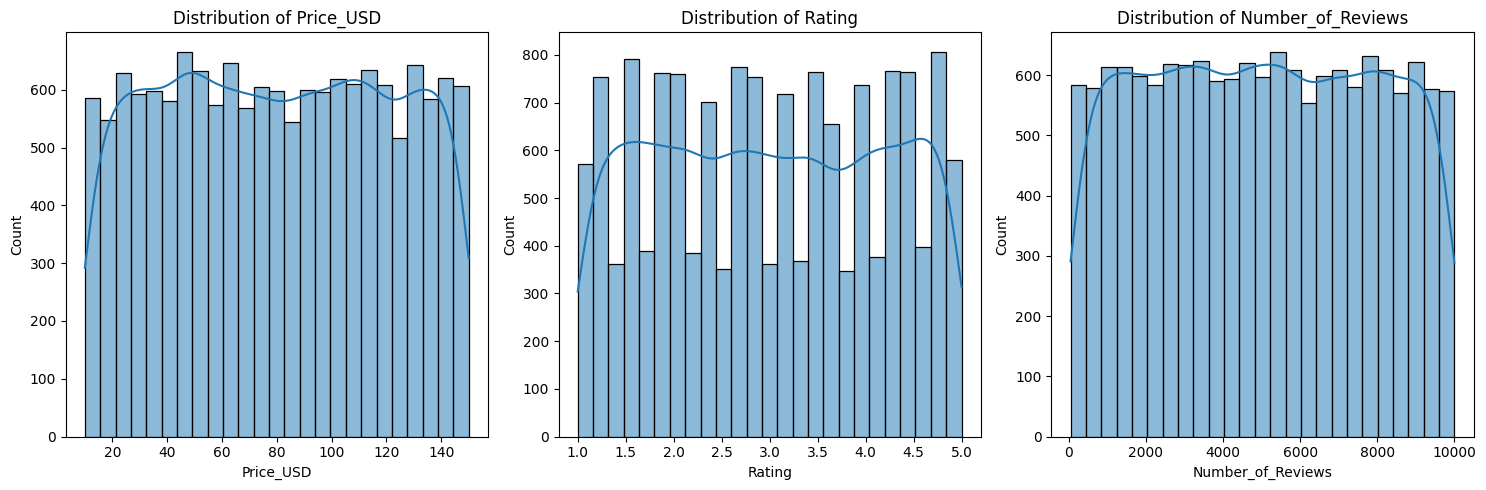

In [42]:
numerical_features = ['Price_USD', 'Rating', 'Number_of_Reviews']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(numerical_features):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
    
plt.tight_layout()
plt.show()

Price_USD: Harga produk bervariasi dengan rata-rata USD 80.13 dan standar deviasi USD 40.40, menunjukkan rentang harga yang lebar dari produk terjangkau hingga premium.  <br>
Rating: Rating rata-rata produk adalah 3.00 (skala 1.0–5.0) dengan standar deviasi 1.17, mengindikasikan variasi kepuasan pengguna. <br>
Number_of_Reviews: Jumlah ulasan rata-rata 5.014, dengan maksimum 10.000, menunjukkan beberapa produk sangat populer.

#### Memeriksa distribusi fitur kategorikal

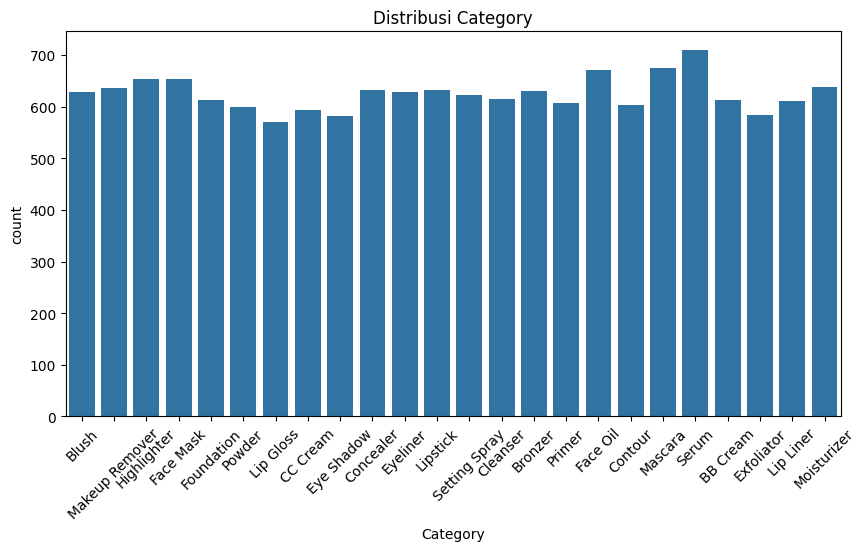

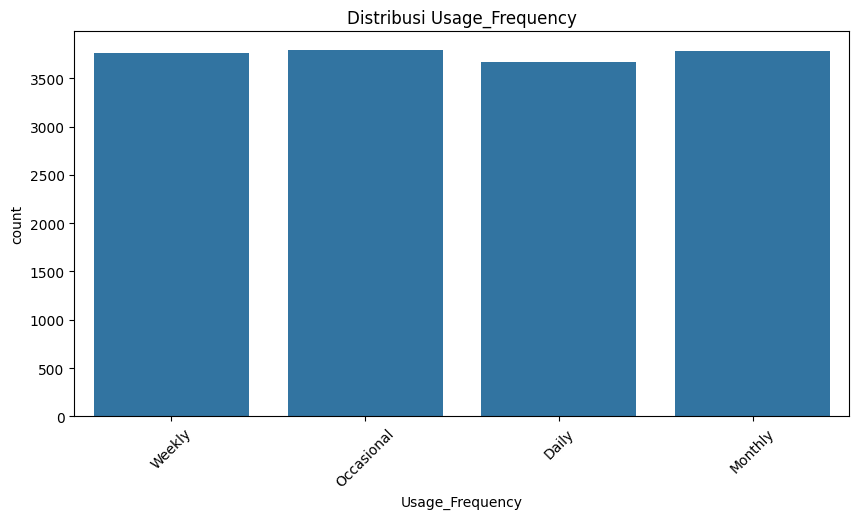

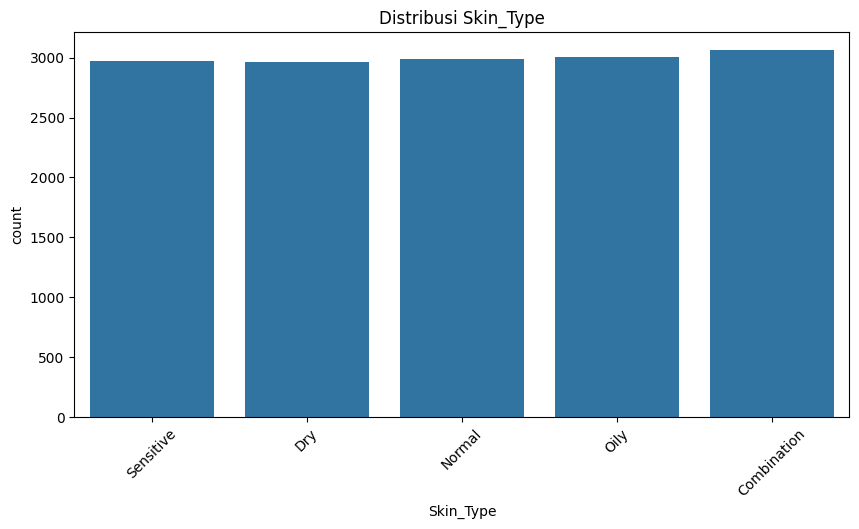

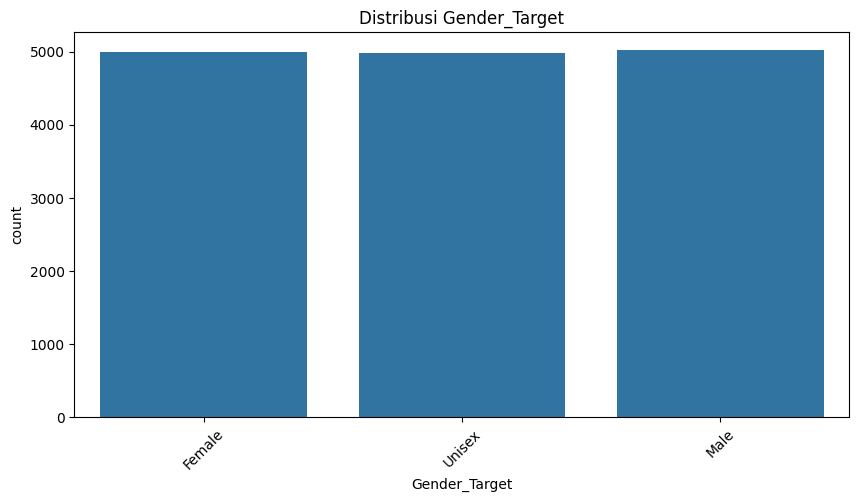

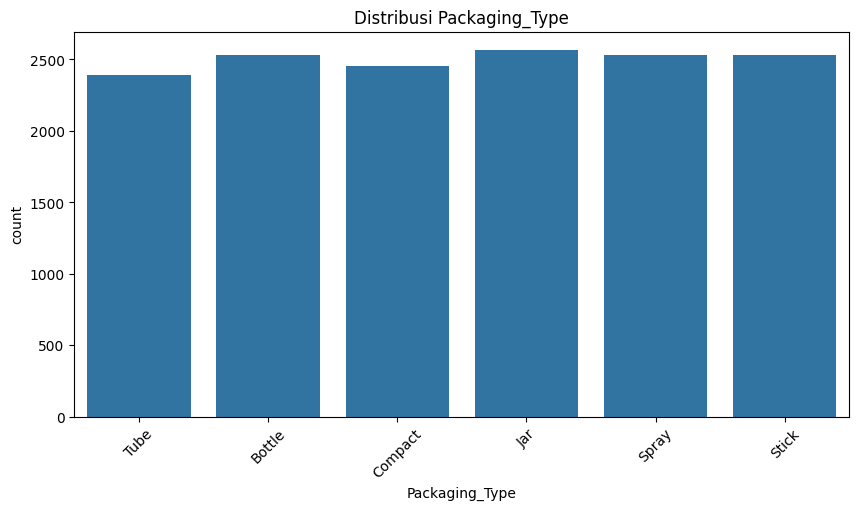

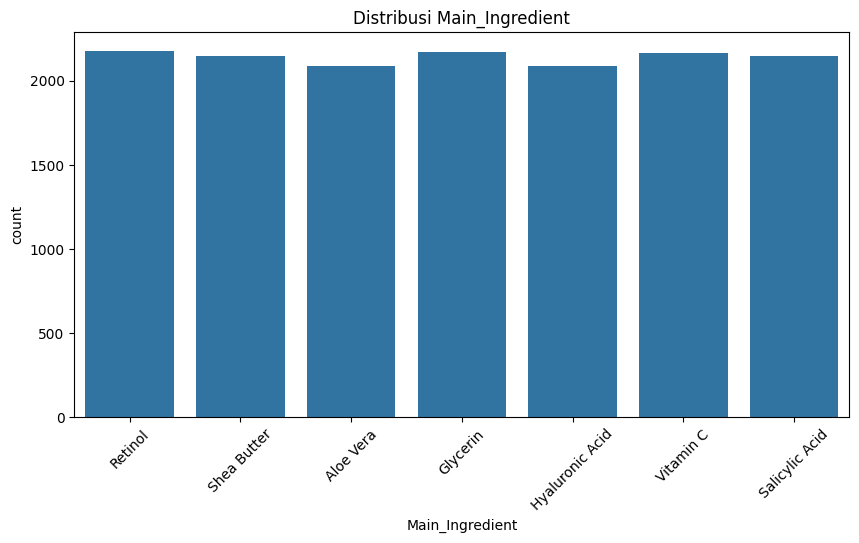

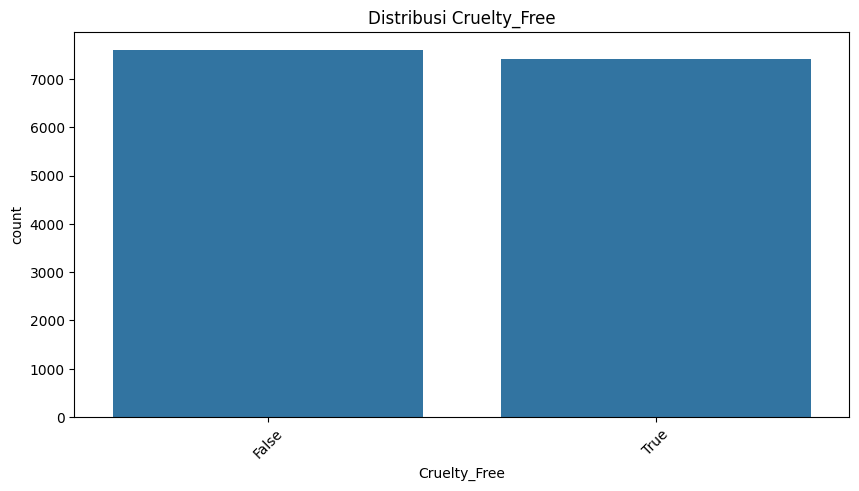

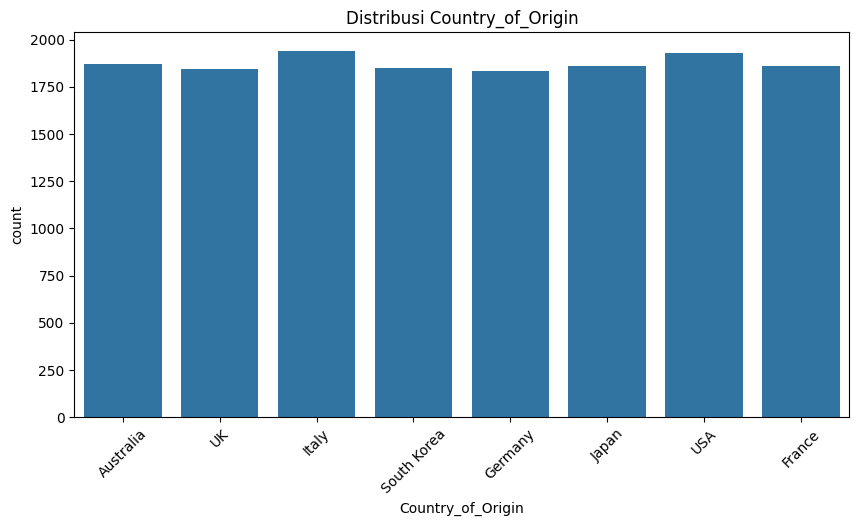

In [43]:
categorical_features = ['Category', 'Usage_Frequency', 'Skin_Type', 'Gender_Target', 'Packaging_Type', 
                        'Main_Ingredient', 'Cruelty_Free', 'Country_of_Origin']
for feature in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=feature)
    plt.xticks(rotation=45)
    plt.title(f'Distribusi {feature}')
    plt.show()

#### Memeriksa korelasi fitur numerik

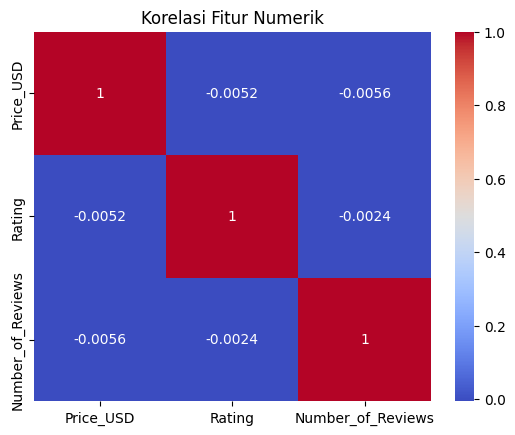

In [44]:
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Korelasi Fitur Numerik')
plt.show()

Heatmap korelasi ini menunjukkan hubungan antar fitur numerik: Price_USD, Rating, dan Number_of_Reviews. Hasilnya memperlihatkan bahwa ketiga fitur tersebut memiliki korelasi yang sangat lemah satu sama lain, dengan nilai mendekati nol. Artinya, harga produk, rating, dan jumlah ulasan cenderung saling independen dan tidak memiliki hubungan linear yang signifikan, sehingga perubahan pada satu fitur tidak bisa digunakan untuk memprediksi fitur lainnya secara langsung.

#### Memeriksa distribusi fitur kategori terhadap rating produk

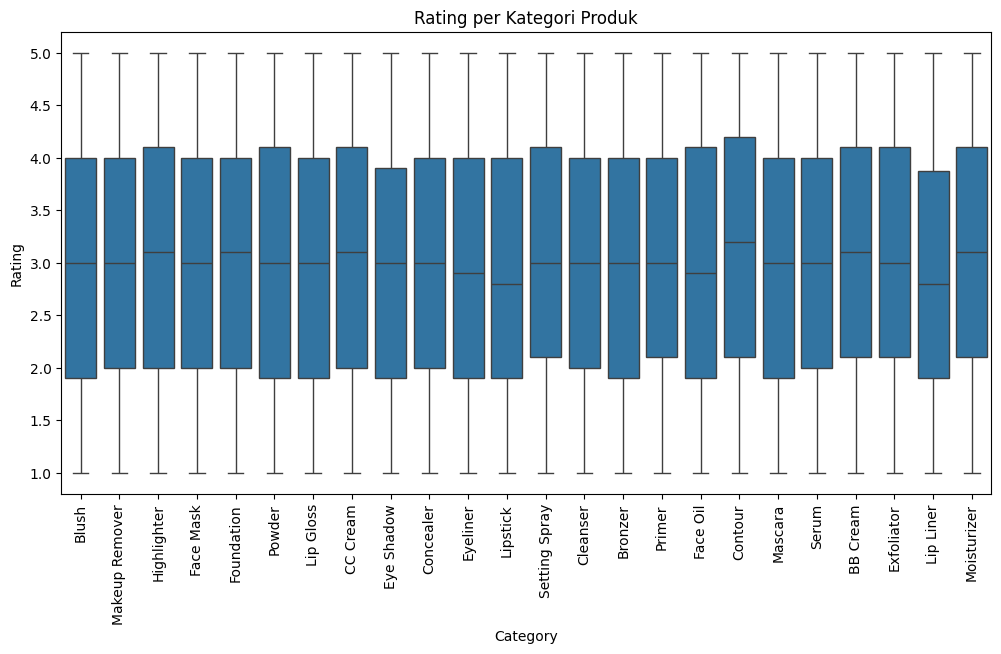

In [45]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Category', y='Rating')
plt.xticks(rotation=90)
plt.title('Rating per Kategori Produk')
plt.show()

Setiap kotak merepresentasikan sebaran rating produk dalam satu kategori, dengan garis tengah sebagai median. Mayoritas kategori memiliki median rating sekitar 3 hingga 3.5, menunjukkan bahwa sebagian besar produk mendapat penilaian cukup baik. Namun, ada variasi lebar boxplot yang mengindikasikan perbedaan penyebaran rating antar kategori, misalnya kategori seperti "Contour" tampak memiliki persebaran rating yang lebih tinggi. 

## Data Preparation

##### Encoding fitur kategorikal

In [46]:
le_brand = LabelEncoder()
le_category = LabelEncoder()
le_skin_type = LabelEncoder()
le_ingredient = LabelEncoder()
le_usage = LabelEncoder()

Fitur kategorikal yang bersifat non-numerik seperti Brand, Category, Skin_Type, Main_Ingredient, dan Usage_Frequency diubah menjadi bentuk numerik menggunakan teknik Label Encoding melalui LabelEncoder dari sklearn.preprocessing.

#### Transformasi fitur kategorikal

In [47]:
df['Brand_Encoded'] = le_brand.fit_transform(df['Brand'])
df['Category_Encoded'] = le_category.fit_transform(df['Category'])
df['Skin_Type_Encoded'] = le_skin_type.fit_transform(df['Skin_Type'])
df['Main_Ingredient_Encoded'] = le_ingredient.fit_transform(df['Main_Ingredient'])
df['Usage_Frequency_Encoded'] = le_usage.fit_transform(df['Usage_Frequency'])

#### Membuat user dummy untuk representasi rating berdasarkan nama produk dan brand

In [48]:
ratings_df = pd.DataFrame({
    'user': ['user_10', 'user_10', 'user_10', 'user_10', 'user_10', 'user_11', 'user_11'],
    'Product_Name': ['Super Foundation', 'Super Moisturizer', 'Divine Exfoliator', 'Super Setting Spray', 
                     'Ultra Highlighter', 'Ultra Face Mask', 'Divine Serum'],
    'Brand': ['Charlotte Tilbury', 'Pat McGrath Labs', 'Make Up For Ever', 'Rare Beauty', 
              'Rare Beauty', 'Drunk Elephant', 'Ilia Beauty'],
    'rating': [4.5, 4.2, 4.8, 4.0, 4.3, 4.0, 2.5]
})

Data user dummy ini <b> hanya digunakan untuk mengevaluasi hasil rekomendasi karena dataset tidak mendukung data riwayat pengguna. </b> DataFrame ratings_df yang berisi data simulasi dummy ulasan pengguna terhadap produk kecantikan. Terdapat dua pengguna (user_10 dan user_11) yang masing-masing memberikan rating terhadap beberapa produk, dengan mencantumkan nama produk (Product_Name), merek (Brand), dan nilai rating numerik.

#### Precompute TF-IDF and cosine similarity

In [49]:
print("Precomputing TF-IDF and cosine similarity...")
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Product_Name'] + ' ' + df['Brand'] + ' ' + 
                                  df['Category'] + ' ' + df['Main_Ingredient'] + ' ' + 
                                  df['Skin_Type'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

Precomputing TF-IDF and cosine similarity...


Untuk membangun sistem rekomendasi berbasis konten (content-based), digunakan metode TF-IDF (Term Frequency-Inverse Document Frequency) dari sklearn.feature_extraction.text.TfidfVectorizer. Hasil dari TF-IDF matrix kemudian digunakan untuk menghitung cosine similarity untuk mengidentifikasi produk lain yang mirip dengan preferensi pengguna.

## Training Model

#### Cache untuk rekomendasi

In [50]:
recommendation_cache = {}

## Content based filtering

In [51]:
def content_based_recommendations(product_name, brand, top_n=5):
    idx = df[(df['Product_Name'] == product_name) & (df['Brand'] == brand)].index
    if len(idx) == 0:
        print(f"Product {product_name} by {brand} not found in dataset")
        return pd.DataFrame([{"Product_Name": "Product Not Found", "Brand": "-", "Category": "-", "Predicted_Rating": 0}])
    idx = idx[0]
    
    sim_scores = sorted(list(enumerate(cosine_sim[idx])), key=lambda x: x[1], reverse=True)[1:top_n+1]
    product_indices = [i[0] for i in sim_scores]
    similarities = [i[1] for i in sim_scores]
    
    result = df[['Product_Name', 'Brand', 'Category']].iloc[product_indices].copy()
    result['Predicted_Rating'] = similarities
    return result.reset_index(drop=True)

Content-Based Filtering, merekomendasikan produk berdasarkan kemiripan fitur atau atribut produk itu sendiri. Fitur-fitur produk yang relevan seperti 'brand', 'Category', dan 'Product_Name' digabungkan menjadi satu teks deskriptif ('result') untuk setiap produk. TF-IDF memberikan bobot pada kata-kata yang penting dalam mendeskripsikan suatu produk relatif terhadap keseluruhan dataset produk. Setelah mendapatkan matriks TF-IDF, kemiripan antar produk dihitung menggunakan cosine similarity. Fungsi ini mengambil nama produk sebagai input, mencari produk tersebut dalam matriks kemiripan, dan mengembalikan top_n produk lain yang paling mirip.

## Fungsi untuk evaluasi

In [52]:
def evaluate_recommendations(recommendations, user_id, ground_truth, k=5, relevance_threshold=4.0):
    try:
        relevant_items = ground_truth[(ground_truth['user'] == user_id) & 
                                     (ground_truth['rating'] >= relevance_threshold)][['Product_Name', 'Brand']]
        
        if relevant_items.empty:
            print(f"No relevant items found for user {user_id} with rating >= {relevance_threshold}")
            return {'Precision@K': 0.0, 'Recall@K': 0.0, 'F1@K': 0.0, 'NDCG@K': 0.0}
        
        recommended_items = recommendations[['Product_Name', 'Brand']].head(k)
        
        relevant_set = set(relevant_items.apply(lambda x: f"{x['Product_Name']}|{x['Brand']}", axis=1))
        recommended_set = set(recommended_items.apply(lambda x: f"{x['Product_Name']}|{x['Brand']}", axis=1))
        
        print(f"Relevant items for user {user_id}: {relevant_set}")
        print(f"Recommended items: {recommended_set}")
        
        relevant_recommended = len(relevant_set.intersection(recommended_set))
        
        precision = relevant_recommended / k if k > 0 else 0.0
        recall = relevant_recommended / len(relevant_set) if relevant_set else 0.0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        true_relevance = np.array([1 if f"{row['Product_Name']}|{row['Brand']}" in relevant_set else 0 
                                  for _, row in recommended_items.iterrows()])
        predicted_relevance = recommendations['Predicted_Rating'].head(k).values if 'Predicted_Rating' in recommendations else np.ones(k)
        ndcg = ndcg_score([true_relevance], [predicted_relevance], k=k) if sum(true_relevance) > 0 else 0.0
        
        return {
            'Precision@K': precision,
            'Recall@K': recall,
            'F1@K': f1,
            'NDCG@K': ndcg
        }
    except Exception as e:
        print(f"Error in evaluation: {str(e)}")
        return {'Precision@K': 0.0, 'Recall@K': 0.0, 'F1@K': 0.0, 'NDCG@K': 0.0}

Fungsi evaluate_recommendations digunakan untuk menghitung tiga metrik utama pada K=5 (artinya kita mengevaluasi 5 item teratas yang direkomendasikan). Sebuah produk dianggap "relevan" bagi pengguna jika pengguna tersebut memberikan rating ≥4.0 pada produk tersebut (relevance_threshold=4.0).

## Pengeksekusian Fungsi

In [53]:
if __name__ == '__main__':
    k = 5
    user_id = 'user_10'
    relevance_threshold = 4.0
    
    # Content based recommendations
    print("\nRECOMMENDATIONS - CONTENT BASED")
    content_recs = content_based_recommendations("Super Foundation", "Charlotte Tilbury")
    print(tabulate(content_recs, headers="keys", tablefmt="grid"))
    
    # Evaluasi Content based recommendations
    print("\nEVALUATION - CONTENT BASED")
    content_metrics = evaluate_recommendations(content_recs, user_id, ratings_df, k=k, relevance_threshold=relevance_threshold)
    print(tabulate([content_metrics], headers="keys", tablefmt="grid"))


RECOMMENDATIONS - CONTENT BASED
+----+---------------------+-------------------+-------------+--------------------+
|    | Product_Name        | Brand             | Category    |   Predicted_Rating |
+====+=====================+===================+=============+====================+
|  0 | Super Foundation    | Charlotte Tilbury | Highlighter |           0.830567 |
+----+---------------------+-------------------+-------------+--------------------+
|  1 | Divine Foundation   | Charlotte Tilbury | Highlighter |           0.794204 |
+----+---------------------+-------------------+-------------+--------------------+
|  2 | Perfect Lipstick    | Charlotte Tilbury | Highlighter |           0.791222 |
+----+---------------------+-------------------+-------------+--------------------+
|  3 | Perfect Highlighter | Charlotte Tilbury | Primer      |           0.789489 |
+----+---------------------+-------------------+-------------+--------------------+
|  4 | Super Lipstick      | Charlotte Tilb